# Evalutation of the v7a-verti-size Sizescan

extract the emittances for all offsets and safe in a csv

In [1]:
import os
import numpy as np
import pandas as pd
import altair as alt
alt.enable_mime_rendering()
import scipy.constants

import PhaseSpaceEval.monitor_quantities as monq
from PhaseSpaceEval.import_particle_data import *
from PhaseSpaceEval.trajectory import Trajectory
from PhaseSpaceEval.particlemonitor import ParticleMonitor

## Import Raw Data and set filename *!!! ADJUST FILENAMES HERE !!!*

In [2]:
MODELNAME = "v7a_verti_size"
RAW_PATH = "rawdata_" + MODELNAME + "/"
EMIT_FILENAME = "sc_emit_" + MODELNAME + ".csv" # Name for the emittance output file
#MON_FILENAME = "mon_" + MODELNAME + ".csv" # Name for the monitors output file

particle_source_names = import_source_names(RAW_PATH + MODELNAME + "-source_names.txt")
particle_constants = import_particle_constants(RAW_PATH + MODELNAME + "-constants.txt")
particle_trajectories = import_particle_trajectories(RAW_PATH + MODELNAME + "-trajectories.txt")

## Create convenient lists
### Raw Data

In [3]:
# Delete the single_centre source, not required
for key in particle_source_names.keys():
    if particle_source_names[key] == "single_centre":
        del(particle_source_names[key])
        break
        
# Generate simple list with all source IDs
sourceIDs = list(particle_source_names.keys())
#print(sourceIDs)

# Create lists with all particles belonging to a source and with the id of the central particles
particlesBySrc = dict() # dict for all particleIDs
centresBySrc = dict() # dict with the ids of the central particles
for sID in sourceIDs:
    pIDs = particle_constants["particleID"].loc[particle_constants["sourceID"] == sID].tolist()
    particlesBySrc.update({sID : pIDs})
    centresBySrc.update({sID : min(pIDs)}) # the smallest pID for each source is the centre
#print(particlesBySrc)
#print(centresBySrc)

### Trajectories

In [4]:
# Create Trajectories
trajsBySrc = dict() # Dict for all trajectories
ctrajsBySrc = dict() # Dict for central trajectories
lostParticles = list()
for sID in sourceIDs:
    # Compute central trajectory for each sID
    cID = centresBySrc[sID]
    ctr = Trajectory(particle_trajectories[cID],
                     particle_constants.loc[particle_constants["particleID"] == cID].squeeze())
    ctrajsBySrc.update({sID : ctr})

    # For each sID compute the trajectories of all pIDs
    # Note Particles that cannot be found in trajectory dataframe, these were lost
    pIDs = particlesBySrc[sID]
    trajs = list()
    for pID in pIDs:
        try:
            tr = Trajectory(particle_trajectories[pID],
                            particle_constants.loc[particle_constants["particleID"] == pID].squeeze())
        except KeyError:
            lostParticles.append(pID)
        trajs.append(tr)
    trajsBySrc.update({sID : trajs})
print(lostParticles)

[2750, 3028, 3079, 3094, 3160, 3195, 3341, 3697, 3717, 3790, 3794, 3799, 3812, 3923, 4028, 4039, 4117, 4119, 4150, 4155, 4165, 4285, 4326, 4331, 4349, 4370, 4409, 4422, 4446, 4453, 4467, 4487, 4499, 4554, 4566, 4606, 4734, 4736, 4814, 4841, 4848, 4851, 4859, 4877, 4897, 4908, 4933, 5007, 5018, 5042, 5067, 5078, 5113, 5120, 5183, 5211, 5241, 5248, 5254, 5264, 5270, 5274, 5286, 5303, 5315, 5324, 5331, 5366, 5393, 5397, 5422, 5504, 5562, 5576, 5592, 5624, 5629, 5662, 5670, 5686, 5736, 5741, 5746, 5766, 5787, 5789, 5800, 5810, 5837, 5848, 5850, 5861, 5889, 5898, 5900, 5901, 5914, 5918, 5928, 5943, 5960, 5962, 6014, 6021, 6030, 6033, 6052, 6060, 6062, 6066, 6071, 6073, 6080, 6084, 6085, 6089, 6094, 6097, 6105, 6106, 6111, 6134, 6136, 6140, 6142, 6143, 6154, 6157, 6161, 6163, 6181, 6186, 6189, 6191, 6192, 6194, 6197, 6199, 6215, 6236, 6239, 6244, 6245, 6256, 6262, 6266, 6282, 6300, 6309, 6316, 6330, 6348, 6365, 6368, 6387, 6410, 6415, 6445, 6464, 6475, 6520, 6536, 6543, 6561, 6569, 6587, 659

### Monitors

In [5]:
# Create Monitors
monBySrc = dict()
for sID in sourceIDs:
    ctr = ctrajsBySrc[sID]
    t0 = ctr.find_time("z", 770)
    mon = ParticleMonitor(time0=t0, trajectory=ctr)
    monBySrc.update({sID : mon})

## Record Monitor Interactions

In [6]:
# Record Monitor Interactions
for sID in sourceIDs:
    mon = monBySrc[sID]
    mon.reset_events()
    mon.reset_misses()
    for tr in trajsBySrc[sID]:
        mon.record_intersect(tr)

# Read Out misses and events
missesBySrc = dict()
eventsBySrc = dict()
for sID in sourceIDs:
    missesBySrc.update({sID : monBySrc[sID].get_misses()})
    eventsBySrc.update({sID : monBySrc[sID].get_events()})
#print(missesBySrc)

# Add lost particles to miss counter
for pID in lostParticles:
    for sID in sourceIDs:
        if pID in particlesBySrc[sID]:
            missesBySrc[sID] += 1
#print(missesBySrc)

## Export Monitor Interactions

In [7]:
'''export_events = pd.DataFrame()
for sID in sourceIDs:
    events = eventsBySrc[sID].copy()
    events["sourceID"] = sID
    events["sourceName"] = particle_source_names[sID]
    export_events = export_events.append(events, ignore_index=True)
export_events.to_csv(MON_FILENAME)'''

'export_events = pd.DataFrame()\nfor sID in sourceIDs:\n    events = eventsBySrc[sID].copy()\n    events["sourceID"] = sID\n    events["sourceName"] = particle_source_names[sID]\n    export_events = export_events.append(events, ignore_index=True)\nexport_events.to_csv(MON_FILENAME)'

## Compute and save emittances

In [8]:
# Compute and save emittances
colnames = ["sourceID", "sourceName", "beamsize", "x_emittance", "y_emittance",
            "x_norm_emittance", "y_norm_emittance", "losses", "relbeta"]
emit_df = pd.DataFrame(columns=colnames)
emit_temp = pd.DataFrame([np.zeros(len(colnames))], columns=colnames)
for sID in sourceIDs:
    name = particle_source_names[sID]
    bs = float(name.split('_')[1])
    xemit = monq.emittance_u(eventsBySrc[sID])
    yemit = monq.emittance_v(eventsBySrc[sID])
    # Compute rel. beta for the screen 1e6 mm/ns ->m/s
    beta = monBySrc[sID].abs_vel / scipy.constants.speed_of_light * 1e6
    xemit_n = beta * (1 - beta**2)**(-0.5) * xemit # beta * gamme * emit
    yemit_n = beta * (1 - beta**2)**(-0.5) * yemit
    losses = missesBySrc[sID]
    
    emit_temp["sourceID"] = sID
    emit_temp["sourceName"] = name
    emit_temp["beamsize"] = bs
    emit_temp["x_emittance"] = xemit
    emit_temp["y_emittance"] = yemit
    emit_temp["x_norm_emittance"] = xemit_n
    emit_temp["y_norm_emittance"] = yemit_n
    emit_temp["losses"] = losses
    emit_temp["relbeta"] = beta

    emit_df = emit_df.append(emit_temp, ignore_index=True)

emit_df.sort_values(["beamsize"], inplace=True)
emit_df.reset_index(inplace=True, drop=True)

# Load emittance data from startinplane to compute relative emittance growth
#emit_start = pd.read_csv("emit_startingplane.csv", index_col=0)
#emit_df["x_emittance_rel"] = emit_df["x_emittance"]/emit_start["x_emittance"]
#emit_df["y_emittance_rel"] = emit_df["y_emittance"]/emit_start["y_emittance"]
# Save emittance table
emit_df.to_csv(EMIT_FILENAME)
# Show head for debugging purposes
emit_df

,sourceID,sourceName,beamsize,x_emittance,y_emittance,x_norm_emittance,y_norm_emittance,losses,relbeta
0,16777217,bs_1,1.0,0.038884,0.038805,0.000090,0.000090,0,0.002308
1,16777218,bs_4,4.0,0.625868,0.614706,0.001445,0.001419,0,0.002308
2,16777219,bs_7,7.0,1.866708,1.756678,0.004309,0.004055,0,0.002308
3,16777220,bs_10,10.0,4.196493,3.780851,0.009687,0.008728,0,0.002308
4,16777221,bs_13,13.0,8.180638,6.529233,0.018885,0.015072,1,0.002308
5,16777222,bs_16,16.0,13.409948,9.296408,0.030956,0.021460,13,0.002308
6,16777223,bs_19,19.0,20.554995,13.331811,0.047450,0.030776,33,0.002308
7,16777224,bs_22,22.0,24.621276,17.627294,0.056837,0.040692,55,0.002308
8,16777225,bs_25,25.0,29.529661,19.231646,0.068168,0.044395,109,0.002308
9,16777226,bs_28,28.0,32.368177,22.979745,0.074720,0.053048,150,0.002308


## Plots

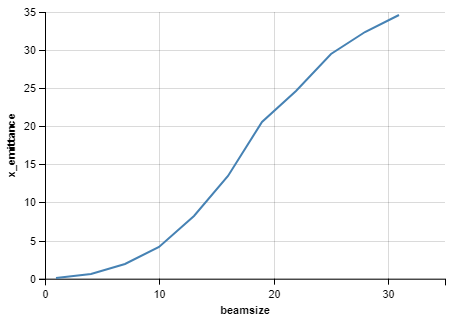

In [9]:
alt.Chart(emit_df).mark_line().encode(
    x='beamsize',
    y='x_emittance',
)

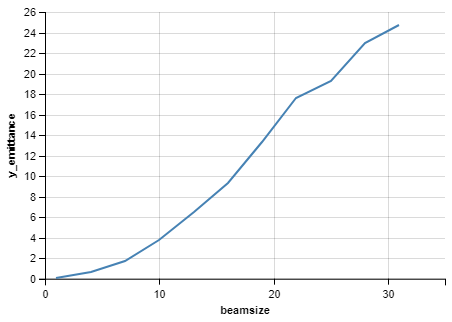

In [10]:
alt.Chart(emit_df).mark_line().encode(
    x='beamsize',
    y='y_emittance',
)

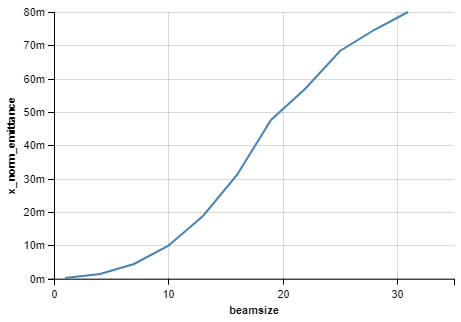

In [11]:
alt.Chart(emit_df).mark_line().encode(
    x='beamsize',
    y='x_norm_emittance',
)

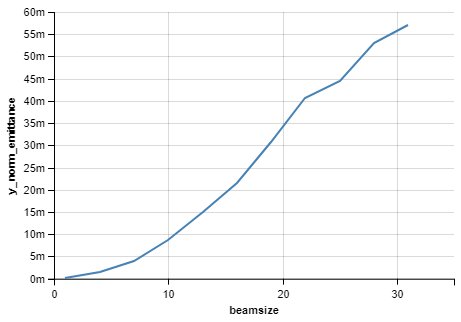

In [12]:
alt.Chart(emit_df).mark_line().encode(
    x='beamsize',
    y='y_norm_emittance',
)

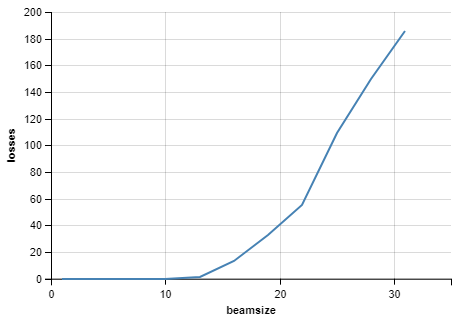

In [13]:
alt.Chart(emit_df).mark_line().encode(
    x='beamsize',
    y='losses',
)